In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

In [3]:
data_dir = "data/dataset_ropa"
categorias = ["tiki", "casi_tiki", "descarte"]
augmented_dir = "data/dataset_ropa_aumentado"

In [8]:
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)
    for category in categorias:
        os.makedirs(os.path.join(augmented_dir, category))

In [4]:
# Parámetros
target_size = (224, 224)
batch_size = 32
num_augmented_images = {"tiki": 15, "casi_tiki": 10, "descarte": 20}

In [ ]:
augmentor = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

for category in categorias:
    input_folder = os.path.join(data_dir, category)
    output_folder = os.path.join(augmented_dir, category)

    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        i = 0
        for batch in augmentor.flow(
            img_array,
            batch_size=1,
            save_to_dir=output_folder,
            save_prefix="aug",
            save_format="jpeg"
        ):
            i += 1
            if i >= num_augmented_images[category]:
                break

KeyboardInterrupt: 

In [5]:
# Generadores de datos
gen_datagen = ImageDataGenerator(
    validation_split=0.2
)

train_generator = gen_datagen.flow_from_directory(
    augmented_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = gen_datagen.flow_from_directory(
    augmented_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 9682 images belonging to 3 classes.
Found 2420 images belonging to 3 classes.


In [6]:
X_val, y_val = [], []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    X_val.extend(x_batch)
    y_val.extend(y_batch)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True 

for layer in base_model.layers[:140]:
    layer.trainable = False


9406464/9406464 [==============================] - 1s 0us/step


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
out = Dense(len(categorias), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)

In [9]:
optimizer = keras.optimizers.AdamW(learning_rate=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
epochs = 50
model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[early_stopping])
model.save("models/modelo.keras")
print("Modelo entrenado y guardado correctamente.")

Epoch 1/50
303/303 [==============================] - 163s 499ms/step - loss: 1.0300 - accuracy: 0.4889 - val_loss: 0.9789 - val_accuracy: 0.4967
Epoch 2/50
303/303 [==============================] - 58s 190ms/step - loss: 0.8437 - accuracy: 0.6032 - val_loss: 0.8419 - val_accuracy: 0.6446
Epoch 3/50
303/303 [==============================] - 59s 195ms/step - loss: 0.7634 - accuracy: 0.6397 - val_loss: 0.7343 - val_accuracy: 0.7074
Epoch 4/50
303/303 [==============================] - 60s 197ms/step - loss: 0.7144 - accuracy: 0.6613 - val_loss: 0.6659 - val_accuracy: 0.7174
Epoch 5/50
303/303 [==============================] - 60s 198ms/step - loss: 0.6847 - accuracy: 0.6739 - val_loss: 0.6187 - val_accuracy: 0.7380
Epoch 6/50
303/303 [==============================] - 60s 197ms/step - loss: 0.6455 - accuracy: 0.6991 - val_loss: 0.5927 - val_accuracy: 0.7545
Epoch 7/50
303/303 [==============================] - 60s 197ms/step - loss: 0.6212 - accuracy: 0.7078 - val_loss: 0.5560 - val_a

2025-04-16 00:15:26.141072: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1457111040 exceeds 10% of free system memory.
2025-04-16 00:15:27.454764: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1457111040 exceeds 10% of free system memory.


76/76 [==============================] - 5s 53ms/step


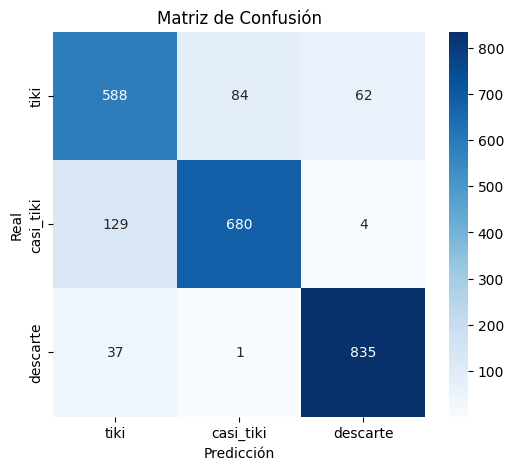

              precision    recall  f1-score   support

        tiki       0.78      0.80      0.79       734
   casi_tiki       0.89      0.84      0.86       813
    descarte       0.93      0.96      0.94       873

    accuracy                           0.87      2420
   macro avg       0.87      0.86      0.86      2420
weighted avg       0.87      0.87      0.87      2420



In [11]:
# Evaluación con matriz de confusión
model = keras.models.load_model("models/modelo.keras")

y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categorias, yticklabels=categorias)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_true, y_pred, target_names=categorias))